# ACCESS Cloud processing - GUNW Product Count
by: Marin Govorcin

In [1]:
%matplotlib widget
import datetime
import time
import requests
import progressbar
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
from ipywidgets import widgets, interact

session = requests.Session()

def get_count_of_products_since_date(start_date):
    search_parameters = {
        'provider': 'ASF',
        'page_size': 0,
        'collection_concept_id': 'C1595422627-ASF',
        'updated_since': start_date.isoformat(timespec='seconds'),
    }
    results = session.get('https://cmr.earthdata.nasa.gov/search/granules.umm_json', params=search_parameters)
    return results.json()['hits']

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield end_date - datetime.timedelta(n), n
        
start_date = datetime.datetime(year=2019, month=6, day=7, tzinfo=datetime.timezone.utc)
total_count = get_count_of_products_since_date(start_date)
print('Total count: {} products, since {}'.format(total_count, str(start_date.date())))

Total count: 797634 products, since 2019-06-07


## Get count per day

In [2]:
#get count per day 
end_date = datetime.datetime.now(tz=datetime.timezone.utc)
count_txt = 'asf_count.csv'

if (Path.cwd()/count_txt).is_file():
    df = pd.read_csv(count_txt)
    df['date'] = pd.to_datetime(df['date'])
    start_date = df.date.max()
else:
    start_date = datetime.datetime(year=2019, month=6, day=7, tzinfo=datetime.timezone.utc)
    df = pd.DataFrame(columns=['date', 'count'])

ndays = (end_date - start_date).days

with progressbar.ProgressBar(max_value=ndays) as bar:
    for date, n in daterange(start_date, end_date):
        count = total_count - get_count_of_products_since_date(date)
        temp_df = pd.DataFrame({'date': [date], 'count': [count]})
        df = pd.concat([df, temp_df], ignore_index=True)
        bar.update(n)
        
## Save result to csv
df['date'] = pd.to_datetime(df['date']) if not df['date'].dtype == 'datetime' else print('df is in correct format')
df.to_csv('asf_count.csv')

- |#                                                  | 0 Elapsed Time: 0:00:00


## Plotting

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 1094), layout=Layout(width='700px'),…

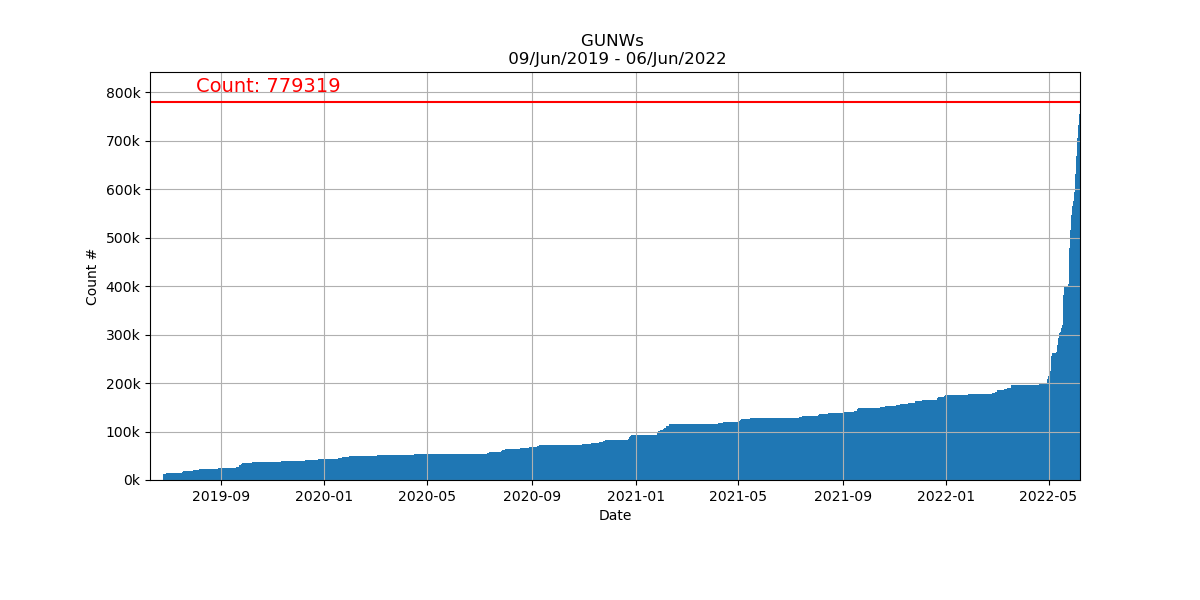

In [3]:
#### PLOT THE COUNT
## Sort it
df = df.sort_values(by=['date'])
options = [(date.strftime('%d/%b/%Y'), date) for date in df['date']]
index = (0, len(options)-1)

selection_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Dates',
    orientation='horizontal',
    layout={'width': '700px'}
)
################################################
figure, ax = plt.subplots(figsize=(12,6), num='ACESS-GUNWs_Growth')
plt.gcf().autofmt_xdate()

def update(date_range):
    plt.cla()
    mask = (df['date'] > date_range[0]) & (df['date'] <= date_range[1])

    line, = ax.plot([min(df['date'][mask]), max(df['date'][mask])], 
                    [max(df['count'][mask]) - min(df['count'][mask]), max(df['count'][mask]) - min(df['count'][mask])],
                    color='red')
    data = ax.bar(df['date'][mask], 
                  df['count'][mask] - min(df['count'][mask]),
                  width=1)
    
    date_range_txt = df[mask].date.min().strftime('%d/%b/%Y') + ' - ' + df[mask].date.max().strftime('%d/%b/%Y')
    txt1 = 'Count: {}'.format(max(df['count'][mask]) - min(df['count'][mask]))
    txt2 = 'GUNWs \n {}'.format(date_range_txt)  
    text = plt.text(0.05,0.95, txt1,fontsize=14,transform=ax.transAxes, color='red')
    
    print('Date range: ', date_range_txt)
    print('Count: ', max(df['count'][mask]) - min(df['count'][mask]))
    
    plt.grid()
    ax.set_title(txt2)
    ax.set_xlim([min(df['date'][mask]), max(df['date'][mask])])
    ax.set_ylim([min(df['count'][mask]) - min(df['count'][mask]), 
                (max(df['count'][mask]) - min(df['count'][mask])) + (max(df['count'][mask]) - min(df['count'][mask]))*0.08])
    ax.set_ylabel('Count #')
    ax.set_xlabel('Date')
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
    
    figure.canvas.draw()
    figure.canvas.flush_events()

widgets.interact(
    update,
    date_range=selection_range_slider
);

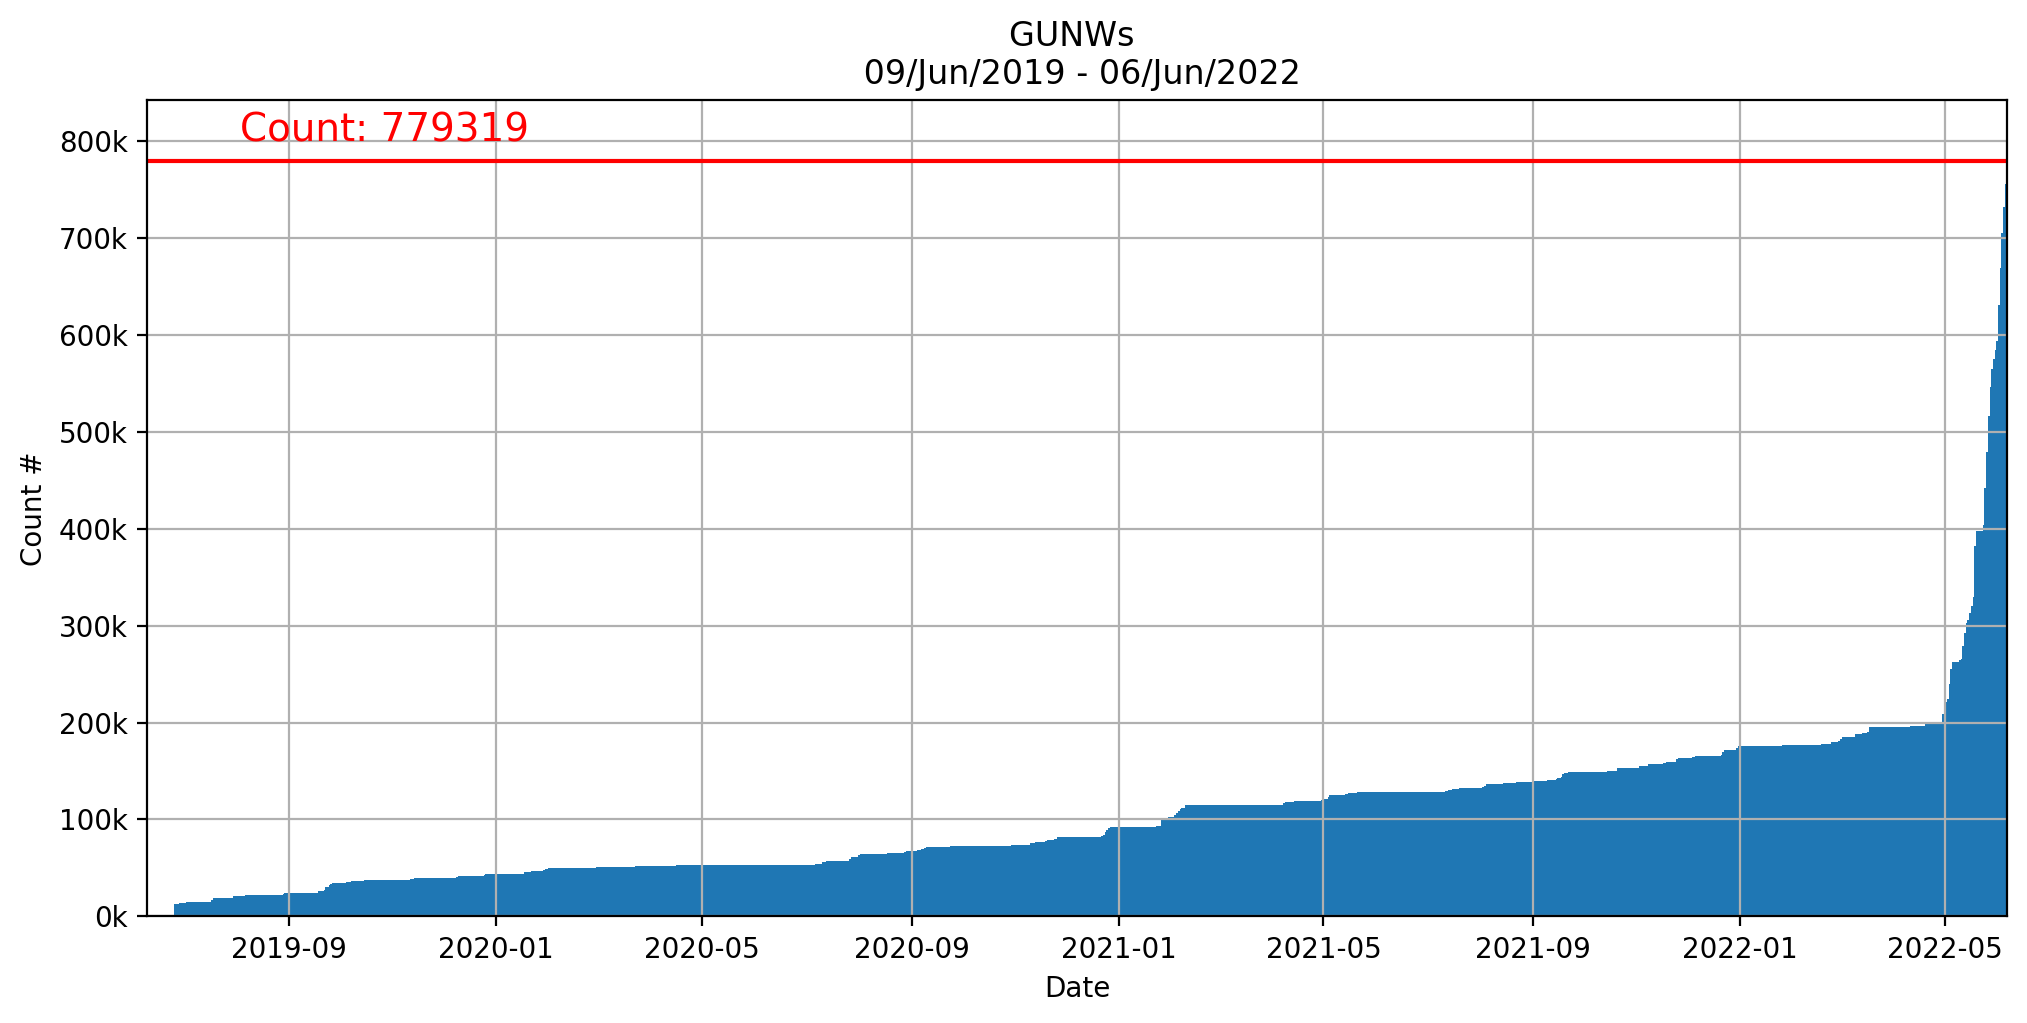

In [5]:
figure